In [1]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from nlp import load_metric

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /home/pouramini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Set up WandB for your project

In [2]:
## Login to WandB and get your API Key
#!wandb login

In [3]:
## Paste your API key in the YOUR_API_KEY variable below
import wandb
YOUR_API_KEY = ''
os.environ["WANDB_API_KEY"] = YOUR_API_KEY
wandb_logger = WandbLogger(project='wikohow-t5')
# wandb.init(project="transformers_tutorials_summarization")

## Load Data using NLP Library

In [4]:
from nlp import list_datasets
datasets_list = list_datasets()
print(', '.join(dataset.id for dataset in datasets_list))

acronym_identification, ade_corpus_v2, adversarial_qa, aeslc, afrikaans_ner_corpus, ag_news, ai2_arc, air_dialogue, ajgt_twitter_ar, allegro_reviews, allocine, alt, amazon_polarity, amazon_reviews_multi, amazon_us_reviews, ambig_qa, amttl, anli, app_reviews, aqua_rat, aquamuse, ar_cov19, ar_res_reviews, ar_sarcasm, arabic_billion_words, arabic_pos_dialect, arabic_speech_corpus, arcd, arsentd_lev, art, arxiv_dataset, ascent_kb, aslg_pc12, asnq, asset, assin, assin2, atomic, autshumato, babi_qa, banking77, bbaw_egyptian, bbc_hindi_nli, bc2gm_corpus, best2009, bianet, bible_para, big_patent, billsum, bing_coronavirus_query_set, biomrc, blended_skill_talk, blimp, blog_authorship_corpus, bn_hate_speech, bookcorpus, bookcorpusopen, boolq, bprec, break_data, brwac, bsd_ja_en, bswac, c3, c4, cail2018, caner, capes, catalonia_independence, cawac, cbt, cc100, cc_news, ccaligned_multilingual, cdsc, cdt, cfq, chr_en, cifar10, cifar100, circa, civil_comments, clickbait_news_bg, climate_fever, clinc

### Select WikiHow data set
See more about it at - https://www.tensorflow.org/datasets/catalog/wikihow

Manual Download required - Download wikihowAll.csv

In [13]:
from datasets import load_dataset
dataset = load_dataset('atomic') #, 'all', data_dir='data/')

Reusing dataset atomic (/home/pouramini/.cache/huggingface/datasets/atomic/atomic/1.1.0/5b81d3243b7cfd2dd0c7f57f2e128f206bf9e758c3bea4487364605c9f3f0dd5)


In [14]:
print(dataset.keys())

dict_keys(['train', 'test', 'validation'])


In [15]:
print("Size of train dataset: ", dataset['train'].shape)

Size of train dataset:  (202271, 12)


In [16]:
print("Size of Validation dataset: ", dataset['validation'].shape)

Size of Validation dataset:  (22620, 12)


We can use the test data set for validation

In [17]:
print("Size of ca test dataset: ", dataset['test'].shape)

Size of ca test dataset:  (24856, 12)


### Look at Examples in this data set

In [18]:
print(dataset['train'][0].keys())

dict_keys(['event', 'oEffect', 'oReact', 'oWant', 'prefix', 'split', 'xAttr', 'xEffect', 'xIntent', 'xNeed', 'xReact', 'xWant'])


In [19]:
print(" Example of text: ", dataset['train'][2]['event'])

 Example of text:  PersonX uses PersonX's ___ to obtain


In [20]:
print(" Example of Summary: ", dataset['train'][0]['xReact'])

 Example of Summary:  ['pleased', 'smug', 'excited']


In [21]:
print(" Example of Title: ", dataset['train'][0]['xWant'])

 Example of Title:  []


### Estimate average length of Text and Summary

In [22]:
tiny_dataset = dataset['train'].select(list(range(0, 100)))
text_len = []
summary_len=[]

In [25]:
for i in range(len(tiny_dataset)):
    example = tiny_dataset[i]
    text_example = example['event']
    text_example = text_example.replace('\n','')
    text_words = text_example.split()
    text_len.append(len(text_words))
    summary_example = example['xReact'][0] if example['xReact'] else ''
    summary_example = summary_example.replace('\n','')
    summary_words = summary_example.split()
    summary_len.append(len(summary_words))

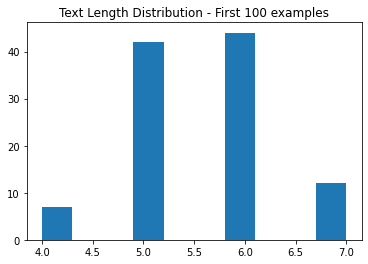

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(text_len)
plt.title('Text Length Distribution - First 100 examples')
plt.show()

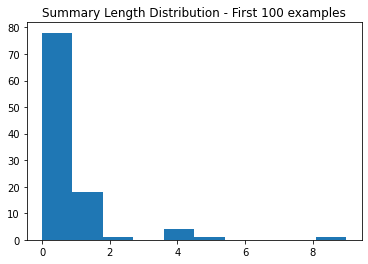

In [27]:
plt.hist(summary_len)
plt.title('Summary Length Distribution - First 100 examples')
plt.show()

In [28]:
print("Average Length of text: ", sum(text_len)/len(text_len))

Average Length of text:  5.580952380952381


In [29]:
print("Average Length of Summary: ", sum(summary_len)/len(summary_len))

Average Length of Summary:  0.4854368932038835


## Define Model

In [30]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [49]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        #self.hparams = hparams        
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        self.rouge_metric = load_metric('rouge') 
        
        if hparams.freeze_embeds:
            self.freeze_embeds()
        if hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
            assert_all_frozen(self.model.get_encoder())
            
            
        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        self.n_obs = {k: v if v >= 0 else None for k, v in n_observations_per_split.items()}
        
    
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
            
    def freeze_embeds(self):
        """Freeze token embeddings and positional embeddings for bart, just token embeddings for t5."""
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))
    

    def is_logger(self):
        return self.trainer.proc_rank <= 0
    
    
    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}
        
    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            lm_labels=lm_labels,
    )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
#         rouge: Dict = self.calc_generative_metrics(preds, target)
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)
        self.rouge_metric.add_batch(preds, target)
        
#         rouge_results = self.rouge_metric.compute() 
#         rouge_dict = self.parse_score(rouge_results)
#         base_metrics.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        return base_metrics
    

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        rouge_results = self.rouge_metric.compute() 
        rouge_dict = self.parse_score(rouge_results)
    
        tensorboard_logs.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "rouge1" : rouge_results['rouge1'],
                "rougeL" : rouge_results['rougeL'],
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
  
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=False):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    

    def train_dataloader(self):   
        n_samples = self.n_obs['train']
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=n_samples, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        n_samples = self.n_obs['validation']
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)
    
    
    def test_dataloader(self):
        n_samples = self.n_obs['test']
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [32]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))

## Define a DataSet class for the loader

In [36]:
class atomic(Dataset):
    def __init__(self, tokenizer, type_path, num_samples, input_length, output_length, print_text=False):         
        self.dataset =  load_dataset('atomic', split=type_path)
        if num_samples:
            self.dataset = self.dataset.select(list(range(0, num_samples)))
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('Example of text:', '')
        text = text.replace('Example of Summary:', '')
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        if self.print_text:
            print("Input Text: ", 
                  self.clean_text(example_batch['event']))
#         input_ = self.clean_text(example_batch['text']) + " </s>"
#         target_ = self.clean_text(example_batch['headline']) + " </s>"
        
        input_ = self.clean_text(example_batch['event'])
        target_ = self.clean_text(example_batch['xReact'][0] if example_batch['xReact'] else '')
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

### Test the dataset function

In [37]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
dataset = atomic(tokenizer, 'validation', None, 512, 150, True)
len(dataset)

Reusing dataset atomic (/home/pouramini/.cache/huggingface/datasets/atomic/atomic/1.1.0/5b81d3243b7cfd2dd0c7f57f2e128f206bf9e758c3bea4487364605c9f3f0dd5)


22620

In [38]:
data = dataset[50]
print()
print("Shape of Tokenized Text: ", data['source_ids'].shape)
print()
print("Sanity check - Decode Text: ", tokenizer.decode(data['source_ids']))
print("====================================")
print("Sanity check - Decode Summary: ", tokenizer.decode(data['target_ids']))

Input Text:  PersonX kills ___ for food

Shape of Tokenized Text:  torch.Size([512])

Sanity check - Decode Text:  PersonX kills ___ for food</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

## Define Arguments

In [39]:
args_dict = dict(
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-small',
    tokenizer_name_or_path='t5-small',
    max_input_length=512,
    max_output_length=150,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=4,
    eval_batch_size=4,
    num_train_epochs=2,
    gradient_accumulation_steps=8,
    n_gpu=1,
    resume_from_checkpoint=None, 
    val_check_interval = 0.05, 
    n_val=1000,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

!mkdir -p t5_wikihow

In [40]:
args_dict.update({'output_dir': 't5_atomic', 'num_train_epochs':2,
                 'train_batch_size': 4, 'eval_batch_size': 4})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'output_dir': 't5_atomic', 'model_name_or_path': 't5-small', 'tokenizer_name_or_path': 't5-small', 'max_input_length': 512, 'max_output_length': 150, 'freeze_encoder': False, 'freeze_embeds': False, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 4, 'eval_batch_size': 4, 'num_train_epochs': 2, 'gradient_accumulation_steps': 8, 'n_gpu': 1, 'resume_from_checkpoint': None, 'val_check_interval': 0.05, 'n_val': 1000, 'n_train': -1, 'n_test': -1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [46]:
## Define Checkpoint function
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args.output_dir, 
    monitor="val_loss", 
    mode="min", save_top_k=3
)

## If resuming from checkpoint, add an arg resume_from_checkpoint
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    resume_from_checkpoint=args.resume_from_checkpoint,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    val_check_interval=args.val_check_interval,
    logger=wandb_logger,
    callbacks=[LoggingCallback()],
)

In [47]:
def get_dataset(tokenizer, type_path, num_samples, args):
      return atomic(tokenizer=tokenizer, type_path=type_path, num_samples=num_samples,  input_length=args.max_input_length, 
                        output_length=args.max_output_length)

## Train Model

In [50]:
model = T5FineTuner(args)

ValueError: Cannot acquire lock, caching file might be used by another process, you should setup a unique 'experiment_id' for this run.

In [30]:
trainer = pl.Trainer(**train_params)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [31]:
trainer.fit(model)

wandb: Wandb version 0.9.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60 M  


/home/priya/miniconda3/envs/huggingface/lib/python3.6/site-packages/transformers/modeling_t5.py:1125: FutureWarning: The `lm_labels` argument is deprecated and will be removed in a future version, use `labels` instead.
  FutureWarning,


Saving latest checkpoint..


1

## Check Model Predictions

In [32]:
import textwrap
from tqdm.auto import tqdm

In [33]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
dataset = atomic(tokenizer, 'test', None, 512, 150, False)

loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /home/priya/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [34]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)
it = iter(loader)

In [35]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [38]:
model.to('cuda')
outs = model.model.generate(
            batch["source_ids"].cuda(),
            attention_mask=batch["source_mask"].cuda(),
            use_cache=True,
            decoder_attention_mask=batch['target_mask'].cuda(),
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [40]:
for i in range(32):
    lines = textwrap.wrap("WikiHow Text:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual Summary: %s" % targets[i])
    print("\nPredicted Summary: %s" % dec[i])
    print("=====================================================================\n")

WikiHow Text: Do this when they're just dried from dew but have not yet had the sun's heat on them.
You'll need about 2 dozen leaves for this recipe.Wash, clean and dry as needed. Pack loosely. Cover
the leaves and fill the jar about 4/5ths. Put the covered jar into the refrigerator for 24 hours to
infuse. Leave as long as you like beyond this time, as the flavor will simply continue to intensify.
Strain the basil leaves out when using the vodka. You can simply add them back to the unused vodka
to keep infusing but don't include them in your cocktails or neat vodka drink as the flavors are now
in the liquid.

Actual Summary: Pick the basil leaves.Pack the basil leaves into a suitable clean jar.Pour your vodka of choice over the leaves.Seal.Use.

Predicted Summary: Prepare the jar.Place the jar in the refrigerator.Add the leaves to the jar.Fill the jar.

WikiHow Text: You'll find out why later. Just stay there for a second, and whatever you do, do NOT
go into his space., Let the door cl

## Testing using AutoModel loader

In [4]:
from transformers import AutoTokenizer, AutoModelWithLMHead
import torch

In [5]:
tokenizer = AutoTokenizer.from_pretrained("deep-learning-analytics/wikihow-t5-small")

model = AutoModelWithLMHead.from_pretrained("deep-learning-analytics/wikihow-t5-small")

In [6]:
## Move to CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [7]:
text = """"
Lack of fluids can lead to dry mouth, which is a leading cause of bad breath. Water
can also dilute any chemicals in your mouth or gut that are causing bad breath., Studies show that
eating 6 ounces of yogurt a day reduces the level of odor-causing compounds in the mouth. In
particular, look for yogurt containing the active bacteria Streptococcus thermophilus or
Lactobacillus bulgaricus., The abrasive nature of fibrous fruits and vegetables helps to clean
teeth, while the vitamins, antioxidants, and acids they contain improve dental health.Foods that can
be particularly helpful include:Apples — Apples contain vitamin C, which is necessary for health
gums, as well as malic acid, which helps to whiten teeth.Carrots — Carrots are rich in vitamin A,
which strengthens tooth enamel.Celery — Chewing celery produces a lot of saliva, which helps to
neutralize bacteria that cause bad breath.Pineapples — Pineapples contain bromelain, an enzyme that
cleans the mouth., These teas have been shown to kill the bacteria that cause bad breath and
plaque., An upset stomach can lead to burping, which contributes to bad breath. Don’t eat foods that
upset your stomach, or if you do, use antacids. If you are lactose intolerant, try lactase tablets.,
They can all cause bad breath. If you do eat them, bring sugar-free gum or a toothbrush and
toothpaste to freshen your mouth afterwards., Diets low in carbohydrates lead to ketosis — a state
in which the body burns primarily fat instead of carbohydrates for energy. This may be good for your
waistline, but it also produces chemicals called ketones, which contribute to bad breath.To stop the
problem, you must change your diet. Or, you can combat the smell in one of these ways:Drink lots of
water to dilute the ketones.Chew sugarless gum or suck on sugarless mints.Chew mint leaves.
"""

In [8]:
preprocess_text = text.strip().replace("\n","")
tokenized_text = tokenizer.encode(preprocess_text, return_tensors="pt").to(device)

In [9]:
summary_ids = model.generate(
            tokenized_text,
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

In [10]:
output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print ("\n\nSummarized text: \n",output)



Summarized text: 
 Drink water.Eat yogurt.Eat fibrous fruits and vegetables.Try teas.Eat lactose-intolerant foods.Eat sugar-free gum.Drink plenty of water.
